# A RenderMan Example

Here is how you can use the RenderMan library to get data from synths. I'll be using [Dexed](https://asb2m10.github.io/dexed/) as the plugin, which is a close model of the Yamaha DX7. 

![](https://i.ytimg.com/vi/bdd_yOCmRUw/hqdefault.jpg)

In [1]:
import utils

# Ignore this. It's just needed because this notebook is also used for testing.
utils.make_matplotlib_nbval_testable()

# Download the Dexed plugin
dexed = utils.download_plugins()
print(dexed)

plugins/dexed-0.9.3-osx/Dexed.vst


## Initializing RenderMan
First, we set up the 'RenderEngine' which hosts the VST plugin and print some basic information on the available parameters.

In [2]:
import librenderman as rm

# Important settings. These are good general ones.
sampleRate = 44100
bufferSize = 512
fftSize = 512

# This will host a VST. It will render the features and audio we need.
engine = rm.RenderEngine(sampleRate, bufferSize, fftSize)

# Load the VST into the RenderEngine.
if not engine.load_plugin(dexed):
    raise Exception('Huh?')

# We can also get a list of available parameter indices and names.
parameters = engine.get_plugin_parameters_description()
print(parameters)

[(0, 'Cutoff'), (1, 'Resonance'), (2, 'Output'), (3, 'MASTER TUNE ADJ'), (4, 'ALGORITHM'), (5, 'FEEDBACK'), (6, 'OSC KEY SYNC'), (7, 'LFO SPEED'), (8, 'LFO DELAY'), (9, 'LFO PM DEPTH'), (10, 'LFO AM DEPTH'), (11, 'LFO KEY SYNC'), (12, 'LFO WAVE'), (13, 'MIDDLE C'), (14, 'P MODE SENS.'), (15, 'PITCH EG RATE 1'), (16, 'PITCH EG RATE 2'), (17, 'PITCH EG RATE 3'), (18, 'PITCH EG RATE 4'), (19, 'PITCH EG LEVEL'), (20, 'PITCH EG LEVEL'), (21, 'PITCH EG LEVEL'), (22, 'PITCH EG LEVEL'), (23, 'OP1 EG RATE 1'), (24, 'OP1 EG RATE 2'), (25, 'OP1 EG RATE 3'), (26, 'OP1 EG RATE 4'), (27, 'OP1 EG LEVEL 1'), (28, 'OP1 EG LEVEL 2'), (29, 'OP1 EG LEVEL 3'), (30, 'OP1 EG LEVEL 4'), (31, 'OP1 OUTPUT LEVE'), (32, 'OP1 MODE'), (33, 'OP1 F COARSE'), (34, 'OP1 F FINE'), (35, 'OP1 OSC DETUNE'), (36, 'OP1 BREAK POINT'), (37, 'OP1 L SCALE DEP'), (38, 'OP1 R SCALE DEP'), (39, 'OP1 L KEY SCALE'), (40, 'OP1 R KEY SCALE'), (41, 'OP1 RATE SCALIN'), (42, 'OP1 A MOD SENS.'), (43, 'OP1 KEY VELOCIT'), (44, 'OP1 SWITCH'),

## Rendering Patches

We can render a patch by getting one from the generator, and rendering it with the engine. We will start with a simple set of parameters that just generate a sine wave.

In [3]:
# The patch
partial_patch = {
    'Cutoff': 1,
    'Output': 1,
    'MASTER TUNE ADJ': 0.5,        # = 0
    'MIDDLE C': 0.5,               # = C3
    'PITCH EG RATE 1': 1,          # = 99
    'PITCH EG RATE 2': 1,
    'PITCH EG RATE 3': 1,
    'PITCH EG RATE 4': 1,
    'PITCH EG LEVEL<19>': 0.50505, # = 50
    'PITCH EG LEVEL<20>': 0.50505,
    'PITCH EG LEVEL<21>': 0.50505,
    'PITCH EG LEVEL<22>': 0.50505,
    'OP1 EG RATE 1': 1,            # = 99
    'OP1 EG RATE 2': 1,
    'OP1 EG RATE 3': 1,
    'OP1 EG RATE 4': 1,
    'OP1 EG LEVEL 1': 1,           # = 99
    'OP1 EG LEVEL 2': 1,
    'OP1 EG LEVEL 3': 1,
    'OP1 EG LEVEL 4': 0,           # = 0
    'OP1 OUTPUT LEVE': 1,          # = 99
    'OP1 F COARSE': 0.0322581,     # = 1
    'OP1 OSC DETUNE': 0.5,         # = 0
    'OP1 BREAK POINT': 0.393939,   # = C3
    'OP1 SWITCH': 1,               # = ON
}

# TODO: hide all this behind a nice higher level API
from collections import Counter
name_count = Counter((name for (idx,name) in parameters))
def unique_name(name, idx):
    if name_count[name] > 1:
        name += "<%d>"% idx
    return name
index_of = {unique_name(name, idx): idx for idx, name in parameters}
patch = { unique_name(name, idx): 0.0 for idx, name in parameters }
patch.update(partial_patch)
patch_tuples = [(index_of[name], value) for name, value in patch.iteritems()]
# end of TODO

engine.set_patch(patch_tuples)


# Settings to play a note and extract data from the synth.
midiNote = 60 # C4
midiVelocity = 127
noteLength = 4.0
renderLength = 5.0

# Render the data. 
engine.render_patch(midiNote, midiVelocity, noteLength, renderLength)

# Get and print the data. Note the audio is automatically made mono, no
# matter what channel size for ease of use.
audio = engine.get_audio_frames()
print("%s length=%d, min=%.5f, max=%.5f, mean=%.5f"
      % (type(audio), len(audio), min(audio), max(audio), sum(audio)/len(audio)))
print(audio[1000:1010])

<type 'list'> length=220672, min=-0.12478, max=0.12832, mean=0.00000
[-0.04210974648594856, -0.03777800872921944, -0.0332145057618618, -0.028755594044923782, -0.024278903380036354, -0.019540345296263695, -0.015028949826955795, -0.010438891127705574, -0.005861946381628513, -0.0010844557546079159]


## Visualising Audio
We are not just limited to listening to audio, we can look at it too visually. We plot the amplitude over time by simply using matplotlib's plot function.

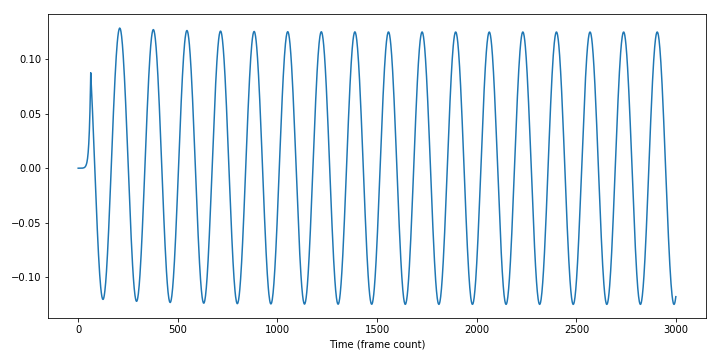

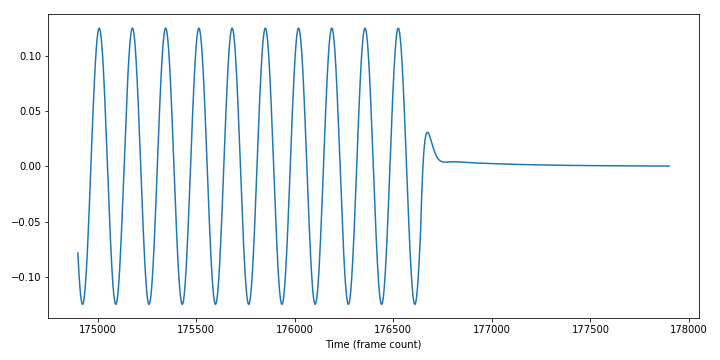

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(audio, from_timestep, to_timestep):
    plt.figure(figsize=(10,5))
    plt.plot(range(from_timestep, to_timestep), audio[from_timestep : to_timestep])
    plt.xlabel('Time (frame count)')
    plt.tight_layout()
    plt.show()

plot(audio, 0, 3000)    
noteEnd = int(noteLength*sampleRate)
plot(audio, noteEnd-1500, noteEnd+1500)

## Spectrograms
We can look at frequency over time by using specgram. The y-axis is the frequency, pass the samplerate as the 'Fs' argument to set the range correctly - remember the Nyquist frequency is half the sample rate! The X-axis is time. 

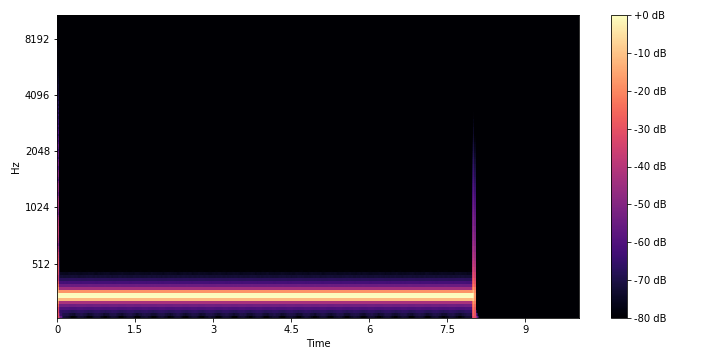

In [5]:
import librosa
import librosa.display
import numpy as np
plt.figure(figsize=(10, 5))
S = librosa.feature.melspectrogram(y=np.array(audio), sr=sampleRate, n_mels=128)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

## Playing The Rendered Audio

If working in a notebook, IPython supplies a easy way to load a mono list of samples into a HTML audio tag. If you aren't using IPython then you can use RenderMan to write to a wav, or use a python library like librosa to write to a wav. 

In [6]:
from IPython.display import Audio

Audio(audio, rate=sampleRate)

## Usage in TensorFlow

TensorFlow creates graphs of operations that allows for efficient machine learning computation on either the CPU using Eigen or the GPU using CUDA and cuDNN. Whilst we can't just throw in python commands in to the TensorFlow graph, we can use RenderMan in machine learning as an op with the use of TensorFlow's [tf.py_func(func, inp, Tout)](https://www.tensorflow.org/versions/r0.9/api_docs/python/script_ops.html#py_func).

TBC!!!

In [7]:
# import tensorflow as tf

# mfcc_feature_rows = len(mfccs[0])
# mfcc_feature_cols = len(mfccs)

# number_plugin_parameters = engine.get_plugin_parameter_size()

# pretend_model_output = tf.placeholder("float", [None,
#                                                 number_plugin_parameters])

# def actual_output(parameters):
#     engine.

# tf.sqrt(tf.reduce_mean(tf.square(tf.sub(targets, pretend_model_output))))